In [100]:
import os
import pandas as pd
import numpy as np

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
%matplotlib inline
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


In [101]:
## consts :

SAMPLE_FREQ = 50 
FILE_MARGINES = 5* SAMPLE_FREQ  ## number of samples to ignore in the  start and in the end of the file (5 seconds )  
WINDOW_SIZE = 128  ## sliding window size 

DEVICE_MODE_LABELS = ['pocket','swing','texting','whatever'] 
USER_MODE_LABELS = ['walking','fastwalking','stairs','static','whatever'] 

FEATURES = ['agforce','agyro','mgforce','mgyro','vgforce','vgyro','maxgforce','maxgyro','mingforce','minxgyro','ampgforce','ampxgyro']


### calulates high level features and add to given data frame 
#### add norm feature for g-force , gyro vectors 
#### calculates additional statistics features  on the norm properties using sliding window 
#### fill NaN values 

In [102]:
def addFeatures(df):
    
    ## norm calculations :
    df['gforce'] = np.sqrt(df['gfx']**2 + df['gFy']**2 + df['gFz']**2) 
    df['gyro'] = np.sqrt(df['wx']**2 + df['wy']**2 + df['wz']**2)     
    
    ## calculates statistics features on rolling window :
    
    df['agforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).mean()
    df['agyro']   = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1 ,center=False).mean()

    df['mgforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).median()
    df['mgyro']   = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1 ,center=False).median()

    df['vgforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).var()
    df['vgyro']   = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).var()

    df['maxgforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).max()
    df['maxgyro']   = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1 ,center=False).max()

    df['mingforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).min()
    df['minxgyro']  = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1 ,center=False).min()

    df['ampgforce'] = df['maxgforce'] - df['mingforce']
    df['ampxgyro']  = df['maxgyro'] - df['gyro']

    ## TODOS : check for NaN's
    ## df['vgforce'].fillna(value=rdf['vgforce'].mean(),min_periods=1,inplace=True)
    ## df['vgyro'].fillna(value=rdf['vgyro'].mean(),inplace=True)

#### read csv data file , add label colomn by parsing the file name 
#### add high level features , crop file edges  
#### Todo : normlize , remove dc 

In [103]:
def loadFile(root,file):
    print 'loading : ' , file 
    data=pd.read_csv(os.path.join(root,file))
    
    ## usefull property : 
    data['source']=file  

    ## default label values in case file name not contains label  
    data['devicemodeDescription']=DEVICE_MODE_LABELS[-1] ## 'whatever' label 
    data['devicemode'] = len(DEVICE_MODE_LABELS)

    ## search device mode label in file name and add as new properties :
    for label in DEVICE_MODE_LABELS:
        if label.lower() in file.lower():  
            data['devicemodeDescription']=label         ## label name 
            data['devicemode'] = DEVICE_MODE_LABELS.index(label)    ## label index 
            break
    
    ## add high level features 
    addFeatures(data)
    
    print len(data) , ' samples loaded '
    print 'all records labeld as ', data['devicemodeDescription'][0]
        
    ## crop samples from start and from the end of the file :
    data.drop(data.index[range(0,FILE_MARGINES)],axis=0,inplace=True)
    data.drop(data.index[range(-FILE_MARGINES,-1)],axis=0,inplace=True)   
    print len(data) , ' samples after cropping ' , FILE_MARGINES , 'samples from start-end of the file  '
    return data

In [104]:
def loadFiles(inputDir):
    print 'loading files from : ' , inputDir 
    return pd.concat([loadFile(inputDir,f) for f in os.listdir(inputDir) if f.lower().endswith('.csv')])  

In [105]:
rdf = loadFiles(r'../all-data/utf8')
print '========================================================='
print 'total train samples ' , len(rdf) 

loading files from :  ../all-data/utf8
loading :  SwingRightPhoneDownScBody.csv
9258  samples loaded 
all records labeld as  swing
8759  samples after cropping  250 samples from start-end of the file  
loading :  PocketLeftStairsUp3.csv
1219  samples loaded 
all records labeld as  pocket
720  samples after cropping  250 samples from start-end of the file  
loading :  swingLeftHandPhoneDownScBody.csv
10608  samples loaded 
all records labeld as  swing
10109  samples after cropping  250 samples from start-end of the file  
loading :  SwingRightPhoneDown.csv
7561  samples loaded 
all records labeld as  swing
7062  samples after cropping  250 samples from start-end of the file  
loading :  PocketLeftStairsDown3.csv
1222  samples loaded 
all records labeld as  pocket
723  samples after cropping  250 samples from start-end of the file  
loading :  TextingStatic2.csv
5380  samples loaded 
all records labeld as  texting
4881  samples after cropping  250 samples from start-end of the file  
loa

In [106]:
rdf.describe()

,Bx,By,Bz,I,Unnamed: 11,Unnamed: 12,agforce,agyro,ampgforce,ampxgyro,...,mgyro,mingforce,minxgyro,p,time,vgforce,vgyro,wx,wy,wz
count,130617.000000,130617.000000,130617.000000,54072.000000,0.0,0.0,130617.000000,130617.000000,130617.000000,130617.000000,...,130617.000000,130617.000000,130617.000000,125031.000000,130617.000000,1.306170e+05,1.306170e+05,130617.000000,130617.000000,130617.00000
mean,1.651477,13.149824,-7.116633,47.342969,NaN,NaN,1.100584,1.584134,1.022189,1.441271,...,1.511047,0.679967,0.538957,977.128272,99.932676,9.393094e-02,7.420777e-01,0.009329,0.004058,0.02412
std,24.651030,23.696896,21.373567,106.449453,NaN,NaN,0.098844,0.931871,0.550081,1.714775,...,0.856777,0.167215,0.386949,3.526550,65.438018,9.174572e-02,1.342132e+00,0.889284,1.305604,1.27520
min,-50.332600,-44.139100,-47.100000,0.000000,NaN,NaN,0.959610,0.000514,0.001182,0.000000,...,0.000316,0.164086,0.000224,968.814600,5.487000,1.101760e-07,2.620800e-08,-6.055000,-12.563800,-5.41530
25%,-19.033800,-3.224200,-26.216100,0.000000,NaN,NaN,1.020220,1.053532,0.668430,0.362296,...,0.985666,0.581319,0.223352,978.035300,45.679000,3.971406e-02,1.116608e-01,-0.437900,-0.349900,-0.78960
50%,5.520000,21.142600,-14.743000,0.000000,NaN,NaN,1.086505,1.587643,1.064696,0.929765,...,1.553846,0.680774,0.509060,978.514200,87.403000,8.010960e-02,3.151086e-01,0.000100,0.000100,-0.00000
75%,23.768600,31.207300,10.464500,10.000000,NaN,NaN,1.146849,2.145325,1.326587,1.833336,...,2.129376,0.775448,0.790661,978.699200,143.683000,1.189558e-01,7.031477e-01,0.368600,0.429500,0.78940
max,288.967900,65.843200,43.527200,387.000000,NaN,NaN,1.492601,5.419855,3.128840,11.674745,...,4.660078,1.012221,2.625822,980.680700,377.232000,5.864526e-01,1.235037e+01,6.345700,11.385500,5.04850


In [107]:
rdf.dropna(axis=1,inplace=True)
rdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130617 entries, 250 to 6823
Data columns (total 27 columns):
Bx                       130617 non-null float64
By                       130617 non-null float64
Bz                       130617 non-null float64
agforce                  130617 non-null float64
agyro                    130617 non-null float64
ampgforce                130617 non-null float64
ampxgyro                 130617 non-null float64
devicemode               130617 non-null int64
devicemodeDescription    130617 non-null object
gFy                      130617 non-null float64
gFz                      130617 non-null float64
gforce                   130617 non-null float64
gfx                      130617 non-null float64
gyro                     130617 non-null float64
maxgforce                130617 non-null float64
maxgyro                  130617 non-null float64
mgforce                  130617 non-null float64
mgyro                    130617 non-null float64
mingforce 

In [108]:
rdf.describe()

,Bx,By,Bz,agforce,agyro,ampgforce,ampxgyro,devicemode,gFy,gFz,...,mgforce,mgyro,mingforce,minxgyro,time,vgforce,vgyro,wx,wy,wz
count,130617.000000,130617.000000,130617.000000,130617.000000,130617.000000,130617.000000,130617.000000,130617.000000,130617.000000,130617.000000,...,130617.000000,130617.000000,130617.000000,130617.000000,130617.000000,1.306170e+05,1.306170e+05,130617.000000,130617.000000,130617.00000
mean,1.651477,13.149824,-7.116633,1.100584,1.584134,1.022189,1.441271,0.915126,-0.533336,0.252098,...,1.065467,1.511047,0.679967,0.538957,99.932676,9.393094e-02,7.420777e-01,0.009329,0.004058,0.02412
std,24.651030,23.696896,21.373567,0.098844,0.931871,0.550081,1.714775,0.729915,0.519888,0.442980,...,0.090733,0.856777,0.167215,0.386949,65.438018,9.174572e-02,1.342132e+00,0.889284,1.305604,1.27520
min,-50.332600,-44.139100,-47.100000,0.959610,0.000514,0.001182,0.000000,0.000000,-2.855300,-2.634600,...,0.804302,0.000316,0.164086,0.000224,5.487000,1.101760e-07,2.620800e-08,-6.055000,-12.563800,-5.41530
25%,-19.033800,-3.224200,-26.216100,1.020220,1.053532,0.668430,0.362296,0.000000,-0.854500,-0.040200,...,1.003662,0.985666,0.581319,0.223352,45.679000,3.971406e-02,1.116608e-01,-0.437900,-0.349900,-0.78960
50%,5.520000,21.142600,-14.743000,1.086505,1.587643,1.064696,0.929765,1.000000,-0.638200,0.102900,...,1.041514,1.553846,0.680774,0.509060,87.403000,8.010960e-02,3.151086e-01,0.000100,0.000100,-0.00000
75%,23.768600,31.207300,10.464500,1.146849,2.145325,1.326587,1.833336,1.000000,-0.213100,0.526400,...,1.093229,2.129376,0.775448,0.790661,143.683000,1.189558e-01,7.031477e-01,0.368600,0.429500,0.78940
max,288.967900,65.843200,43.527200,1.492601,5.419855,3.128840,11.674745,2.000000,1.340800,1.761300,...,1.588012,4.660078,1.012221,2.625822,377.232000,5.864526e-01,1.235037e+01,6.345700,11.385500,5.04850


### visualize

In [109]:
cor_mat = rdf[FEATURES + ['devicemode']] .corr()
cor_mat

,agforce,agyro,mgforce,mgyro,vgforce,vgyro,maxgforce,maxgyro,mingforce,minxgyro,ampgforce,ampxgyro,devicemode
agforce,1.000000,0.695680,0.877313,0.761624,0.677757,0.371508,0.789155,0.469475,-0.264495,0.603742,0.694623,0.247494,-0.333182
agyro,0.695680,1.000000,0.584280,0.966182,0.632613,0.730458,0.635500,0.907218,-0.533643,0.762815,0.656845,0.669252,-0.748930
mgforce,0.877313,0.584280,1.000000,0.636797,0.568268,0.333073,0.624230,0.399491,-0.250961,0.486907,0.562143,0.224998,-0.255123
mgyro,0.761624,0.966182,0.636797,1.000000,0.588554,0.585557,0.656907,0.802165,-0.454983,0.732021,0.649595,0.545024,-0.701276
vgforce,0.677757,0.632613,0.568268,0.588554,1.000000,0.588568,0.866578,0.577650,-0.747039,0.590501,0.901568,0.415623,-0.377278
vgyro,0.371508,0.730458,0.333073,0.585557,0.588568,1.000000,0.384862,0.884575,-0.501966,0.452297,0.452137,0.786637,-0.507338
maxgforce,0.789155,0.635500,0.624230,0.656907,0.866578,0.384862,1.000000,0.464461,-0.637794,0.652147,0.972206,0.268841,-0.312067
maxgyro,0.469475,0.907218,0.399491,0.802165,0.577650,0.884575,0.464461,1.000000,-0.566807,0.627131,0.533802,0.833593,-0.724941
mingforce,-0.264495,-0.533643,-0.250961,-0.454983,-0.747039,-0.501966,-0.637794,-0.566807,1.000000,-0.461865,-0.800395,-0.456489,0.381309
minxgyro,0.603742,0.762815,0.486907,0.732021,0.590501,0.452297,0.652147,0.627131,-0.461865,1.000000,0.647983,0.418702,-0.527288


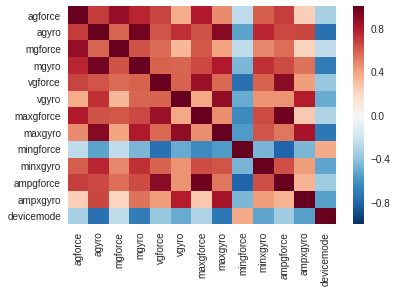

In [110]:
sns.heatmap(cor_mat)

## split train & test data

In [111]:
# take only relevants features :
df = rdf[FEATURES]
df.head()

,agforce,agyro,mgforce,mgyro,vgforce,vgyro,maxgforce,maxgyro,mingforce,minxgyro,ampgforce,ampxgyro
250,1.314327,2.358790,1.301040,2.631593,0.132965,0.680789,2.094436,3.294189,0.74283,0.618111,1.351606,1.076798
251,1.315529,2.364974,1.304636,2.631593,0.132745,0.674055,2.094436,3.294189,0.74283,0.618111,1.351606,1.076798
252,1.316730,2.371158,1.304636,2.631593,0.132521,0.667243,2.094436,3.294189,0.74283,0.618111,1.351606,1.076798
253,1.319528,2.373912,1.304636,2.631593,0.131412,0.662967,2.094436,3.294189,0.74283,0.618111,1.351606,1.515887
254,1.322326,2.376665,1.304636,2.631593,0.130288,0.658675,2.094436,3.294189,0.74283,0.618111,1.351606,1.515887


In [112]:
x_train, x_test, y_train, y_test = train_test_split(df, rdf.devicemode, test_size=0.3, random_state=42)

[[12152     0     0]
 [   12 18055     0]
 [    3     2  8962]]


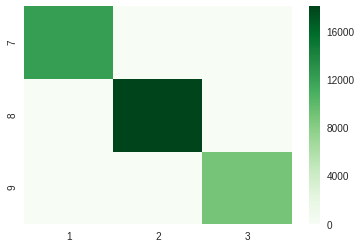

In [113]:
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(x_train,y_train)
knn5_pred = knn.predict(x_test)
print(confusion_matrix(y_pred=knn5_pred,y_true=y_test))
sns.heatmap(xticklabels=range(1,10),yticklabels=range(1,10),data = confusion_matrix(y_pred=knn5_pred,y_true=y_test),cmap='Greens')

In [114]:
print('classification report results:\r\n' + classification_report(y_pred=knn4_pred,y_true=y_test))

classification report results:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     12152
          1       1.00      1.00      1.00     18067
          2       1.00      1.00      1.00      8967

avg / total       1.00      1.00      1.00     39186



In [115]:
accuracy_score(y_test,knn4_pred)

0.99956617159189509

### cross validation : 

In [116]:

def CalcKFoldAccuracy(classifier,X,Y,scoring,k):
    return cross_val_score(classifier, X, Y, cv=k, scoring=scoring).mean()

In [117]:
forest = RandomForestClassifier()
tree = DecisionTreeClassifier()


In [118]:
k=5
scoring ='accuracy'

print ('KNN : ')
print (CalcKFoldAccuracy(knn5,x_train,y_train,scoring,k))
print ('RF : ')
print (CalcKFoldAccuracy(forest,x_train,y_train,scoring,k))
print ('Tree : ')
print (CalcKFoldAccuracy(tree,x_train,y_train,scoring,k))

KNN : 
0.999135958178
RF : 
0.999956250684
Tree : 
0.999650007861


### load validation 

In [119]:
rvl = loadFiles(r'../raw-data/validation/utf8')

loading files from :  ../raw-data/validation/utf8
loading :  swing_walk2017-09-0316.04.51.csv
11775  samples loaded 
all records labeld as  swing
11276  samples after cropping  250 samples from start-end of the file  
loading :  texting_walk2017-09-0315.53.12.csv
4329  samples loaded 
all records labeld as  texting
3830  samples after cropping  250 samples from start-end of the file  
loading :  pocket_walk2017-09-0408.58.13.csv
1099  samples loaded 
all records labeld as  pocket
600  samples after cropping  250 samples from start-end of the file  


In [120]:
rvl.dropna(axis=1,inplace=True)
rvl.drop("source",axis=1).head()

,time,gfx,gFy,gFz,ax,ay,az,wx,wy,wz,...,mgforce,mgyro,vgforce,vgyro,maxgforce,maxgyro,mingforce,minxgyro,ampgforce,ampxgyro
250,4.190,0.0469,0.4652,0.8912,-0.1122,0.1758,-0.0841,0.0318,0.0,-0.0049,...,1.010075,0.065903,0.000149,0.002113,1.045193,0.187975,0.987903,0.030161,0.05729,0.155799
251,4.219,0.0508,0.4730,0.8834,-0.1122,0.1758,-0.0841,0.0318,0.0,-0.0049,...,1.010075,0.065903,0.000149,0.002129,1.045193,0.187975,0.987903,0.030161,0.05729,0.155799
252,4.222,0.0469,0.4730,0.8912,-0.1122,0.1758,-0.0841,0.0318,0.0,-0.0049,...,1.010075,0.065903,0.000149,0.002144,1.045193,0.187975,0.987903,0.030161,0.05729,0.155799
253,4.234,0.0430,0.4652,0.8990,-0.1122,0.1758,-0.0841,0.0318,0.0,-0.0049,...,1.010075,0.065903,0.000149,0.002159,1.045193,0.187975,0.987903,0.030161,0.05729,0.155799
254,4.255,0.0469,0.4613,0.8951,-0.1122,0.1758,-0.0841,0.0318,0.0,-0.0049,...,1.010061,0.065903,0.000147,0.002173,1.045193,0.187975,0.987903,0.030161,0.05729,0.155799


In [121]:
vl = rvl[FEATURES]
vl.head()

,agforce,agyro,mgforce,mgyro,vgforce,vgyro,maxgforce,maxgyro,mingforce,minxgyro,ampgforce,ampxgyro
250,1.012731,0.079365,1.010075,0.065903,0.000149,0.002113,1.045193,0.187975,0.987903,0.030161,0.05729,0.155799
251,1.012735,0.078886,1.010075,0.065903,0.000149,0.002129,1.045193,0.187975,0.987903,0.030161,0.05729,0.155799
252,1.012759,0.078406,1.010075,0.065903,0.000149,0.002144,1.045193,0.187975,0.987903,0.030161,0.05729,0.155799
253,1.012729,0.077926,1.010075,0.065903,0.000149,0.002159,1.045193,0.187975,0.987903,0.030161,0.05729,0.155799
254,1.012579,0.077447,1.010061,0.065903,0.000147,0.002173,1.045193,0.187975,0.987903,0.030161,0.05729,0.155799


[[ 231   26  343]
 [3273 6363 1640]
 [  10    7 3813]]


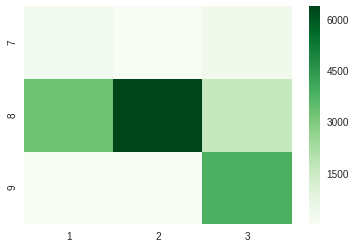

In [125]:
knn5_val = knn5.predict(vl)
print(confusion_matrix(y_pred=knn5_val,y_true=rvl.devicemode))
sns.heatmap(xticklabels=range(1,10),yticklabels=range(1,10),data = confusion_matrix(y_pred=knn5_val,y_true=rvl.devicemode),cmap='Greens')

In [127]:
print('classification report results:\r\n' + classification_report(y_pred=knn5_val,y_true=rvl.devicemode))

classification report results:
             precision    recall  f1-score   support

          0       0.07      0.39      0.11       600
          1       0.99      0.56      0.72     11276
          2       0.66      1.00      0.79      3830

avg / total       0.88      0.66      0.71     15706



In [128]:
accuracy_score(rvl.devicemode,knn5_val)

0.66261301413472562